# Getting started

This notebook shows how to get started with Quantus on tensorflow

In [1]:
import numpy as np # noqa
import pandas as pd
import matplotlib.pyplot as plt # noqa
import tensorflow as tf # noqa
import tensorflow_datasets as tfds

import quantus

## 1. Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [2]:
# Load datasets
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
ds_train.element_spec

(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [3]:
# Build a training pipeline
ds_train = ds_train.shuffle(128)
ds_train = ds_train.batch(128, drop_remainder=True)
ds_train = ds_train.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
ds_train = ds_train.cache()
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_train.element_spec

(TensorSpec(shape=(128, 28, 28, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128,), dtype=tf.int64, name=None))

In [4]:
# Build an evaluation pipeline
ds_test = ds_test.shuffle(128)
ds_test = ds_test.batch(128, drop_remainder=True)
ds_test = ds_test.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
ds_test.element_spec

(TensorSpec(shape=(128, 28, 28, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128,), dtype=tf.int64, name=None))

In [ ]:
x_batch, y_batch = ds_train.take(1).as_numpy_iterator().next()

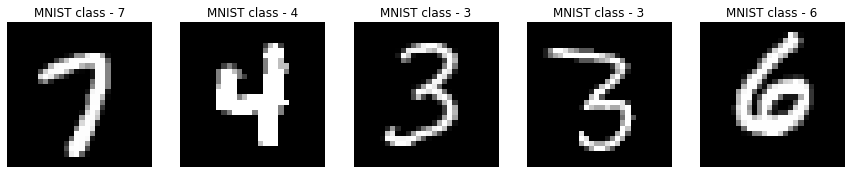

In [6]:
# Plot some inputs!
nr_images = 5

fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))

for i, (x, y) in enumerate(zip(x_batch[:nr_images], y_batch[:nr_images])):
    axes[i].imshow(x.astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"MNIST class - {y}")
    axes[i].axis("off")

### 1.2 Train a model

In [8]:
model = quantus.cnn_2d_tf(28, 28, 10)
model.fit(ds_train, epochs=5, validation_data=ds_test)

Epoch 1/5
468/468 [==============================] - 66s 135ms/step - loss: 0.2303 - accuracy: 0.9304 - val_loss: 0.0614 - val_accuracy: 0.9795
Epoch 2/5
468/468 [==============================] - 61s 130ms/step - loss: 0.0548 - accuracy: 0.9829 - val_loss: 0.0487 - val_accuracy: 0.9844
Epoch 3/5
468/468 [==============================] - 59s 127ms/step - loss: 0.0390 - accuracy: 0.9879 - val_loss: 0.0467 - val_accuracy: 0.9855
Epoch 4/5
468/468 [==============================] - 65s 140ms/step - loss: 0.0300 - accuracy: 0.9901 - val_loss: 0.0395 - val_accuracy: 0.9875
Epoch 5/5
468/468 [==============================] - 51s 108ms/step - loss: 0.0249 - accuracy: 0.9921 - val_loss: 0.0364 - val_accuracy: 0.9891


### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [10]:
# Generate Integrated Gradients attributions of the first batch of the test set.
explain_kwargs = {
    'method': 'GradCam',
    'gc_layer': 'test_conv'
}
a_batch = quantus.explain(model, x_batch, y_batch, **explain_kwargs)
a_batch.shape

(128, 28, 28, 3)

Visualise attributions given model and pairs of input-output.

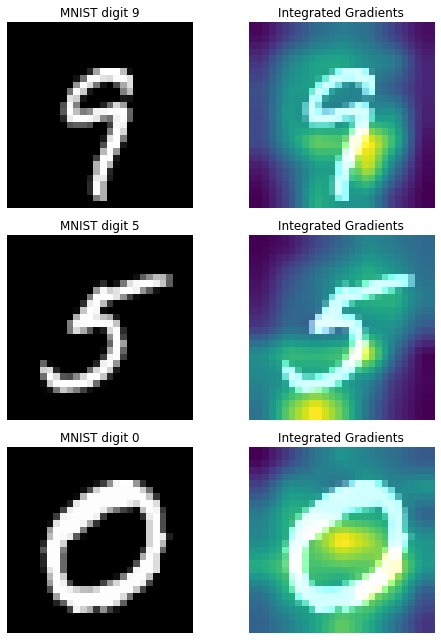

In [21]:
# Plot explanations!
nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images*2.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow(x_batch[i].astype(np.uint8))
    axes[i, 0].title.set_text(f"MNIST digit {y_batch[i].item()}")
    axes[i, 0].axis("off")
    a = axes[i, 1].imshow(a_batch[i])
    axes[i, 1].title.set_text(f"Integrated Gradients")
    axes[i, 1].axis("off")
plt.tight_layout()

## 2. Quantative evaluation using Quantus

We can evaluate our explanations on a variety of quantuative criteria but as a motivating example we test the Max-Sensitivity (Yeh at el., 2019) of the explanations. This metric tests how the explanations maximally change while subject to slight perturbations.

In [35]:
params_eval_maxs = {
    "nr_samples": 10,
    "perturb_radius": 0.1,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_noise,
    "similarity_func": quantus.difference,
    "disable_warnings": True,
    "normalise": True,
    "abs": True,
    "display_progressbar": True,
}


metrics = {"max-Sensitivity": quantus.MaxSensitivity(**params_eval_maxs)}
xai_methods = {"GradCam": a_batch.reshape((128, 3, 28, 28))}

results = quantus.evaluate(
    evaluation_metrics=metrics,
    explanation_methods=xai_methods,
    model=model,
    x_batch=x_batch,
    y_batch=y_batch,
    agg_func=np.mean,
    metrics=metrics,
    xai_methods=xai_methods,
    explain_func=quantus.explain,
    **explain_kwargs
)

pd.DataFrame(results)

Evaluation of MaxSensitivity:   0%|          | 0/128 [00:00<?, ?it/s]/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/helpers/explanation_func.py:52: UserWarning: Using quantus 'explain' function as an explainer without specifying 'attributor'in kwargs will produce a vanilla 'Gradient' explanation.

  warnings.warn(
Evaluation of MaxSensitivity: 100%|██████████| 128/128 [00:20<00:00,  6.11it/s]


,GradCam
max-Sensitivity,0.000024


## [Selectivity](https://arxiv.org/pdf/1706.07979.pdf)

In [44]:
# FIXME
params_eval_slct = {
    "display_progressbar": True,
    "disable_warnings": True,
    "perturb_func": quantus.random_noise,

}

slct = quantus.Selectivity(**params_eval_slct)
scores_intgrad_slct = slct(
    model=model,
    x_batch=x_batch,
    y_batch=y_batch,
    a_batch=a_batch.reshape((128, 3, 28, 28)),
)

scores_intgrad_slct

Evaluation of Selectivity: 100%|██████████| 128/128 [33:04<00:00, 15.51s/it]


{0: [0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955415725708,
  0.999955

## [Relative Stability](https://arxiv.org/pdf/2203.06877.pdf)

In [11]:
relative_stability_params = {
    'display_progressbar': True,
    'return_aggregate': True,
}

ris = quantus.RelativeInputStability(**relative_stability_params)

ris_result = ris(model=model, x_batch=x_batch, y_batch=y_batch, explain_func=quantus.explain, **explain_kwargs)
ris_result

No "perturb_func" provided, using random noise as default


0.33172944

In [12]:
ros = quantus.RelativeOutputStability(**relative_stability_params)
ros_result = ros(model=model, x_batch=x_batch, y_batch=y_batch, explain_func=quantus.explain, **explain_kwargs)
ros_result

No "perturb_func" provided, using random noise as default


4443268.0

As relative representation stability leverages explanation change as subject to change in internal representations,
it could be sensitive to choice of them (internal representations). So let's try different options out!

In [13]:
rrs = quantus.RelativeRepresentationStability(**relative_stability_params)

rrs_result_1 = rrs(model=model, x_batch=x_batch, y_batch=y_batch, explain_func=quantus.explain, **explain_kwargs)
rrs_result_2 = rrs(model=model, x_batch=x_batch, y_batch=y_batch, explain_func=quantus.explain,
                   layer_names=['test_conv'], **explain_kwargs)
rrs_result_3 = rrs(model=model, x_batch=x_batch, y_batch=y_batch, explain_func=quantus.explain,
                   layer_indices=[7, 8], **explain_kwargs)

df = pd.DataFrame()
df['description'] = ['all layers', 'last conv layers', '2 last hidden layers']
df['rrs'] = [rrs_result_1, rrs_result_2, rrs_result_3]
df

No "perturb_func" provided, using random noise as default


No "perturb_func" provided, using random noise as default


No "perturb_func" provided, using random noise as default


,description,rrs
0,all layers,7.351668e+05
1,last conv layers,2.741306e+05
2,2 last hidden layers,4.080848e+06
